In [23]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [38]:
# Here we select first 500 images and convert them to grayscale format
# I also added resize method, since some of the images a little bit bigger and it seems to be more convenient to use images of the same size

input_folder = "img_align_celeba"
output_folder = "celeba_grayscale"  # Folder to save grayscale images

# Create output folder
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through all images in the input folder
for filename in sorted(os.listdir(input_folder))[:500]:
    if filename.endswith(".jpg"):  # CelebA images are in JPG format
        # Load the image
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path)

        # Convert to grayscale
        grayscale_image = image.convert("L")
        grayscale_image = grayscale_image.resize((128, 128), Image.Resampling.LANCZOS)

        # Save the grayscale image
        output_path = os.path.join(output_folder, filename)
        grayscale_image.save(output_path)

        print(f"Processed: {filename}")

print("All images converted to grayscale!")

Processed: 000001.jpg
Processed: 000002.jpg
Processed: 000003.jpg
Processed: 000004.jpg
Processed: 000005.jpg
Processed: 000006.jpg
Processed: 000007.jpg
Processed: 000008.jpg
Processed: 000009.jpg
Processed: 000010.jpg
Processed: 000011.jpg
Processed: 000012.jpg
Processed: 000013.jpg
Processed: 000014.jpg
Processed: 000015.jpg
Processed: 000016.jpg
Processed: 000017.jpg
Processed: 000018.jpg
Processed: 000019.jpg
Processed: 000020.jpg
Processed: 000021.jpg
Processed: 000022.jpg
Processed: 000023.jpg
Processed: 000024.jpg
Processed: 000025.jpg
Processed: 000026.jpg
Processed: 000027.jpg
Processed: 000028.jpg
Processed: 000029.jpg
Processed: 000030.jpg
Processed: 000031.jpg
Processed: 000032.jpg
Processed: 000033.jpg
Processed: 000034.jpg
Processed: 000035.jpg
Processed: 000036.jpg
Processed: 000037.jpg
Processed: 000038.jpg
Processed: 000039.jpg
Processed: 000040.jpg
Processed: 000041.jpg
Processed: 000042.jpg
Processed: 000043.jpg
Processed: 000044.jpg
Processed: 000045.jpg
Processed:

In [16]:
# Here we convert grayscale images to the arrays
image_folder = "celeba_grayscale"  # Folder containing grayscale images
# Parameters
image_size = (128, 128)  # Desired image size

# Load and preprocess images
image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
num_images = len(image_files)
images = []

for filename in image_files:
    # Load the image
    image_path = os.path.join(image_folder, filename)
    image = Image.open(image_path)

    # Convert to NumPy array and normalize pixel values to [0, 1]
    image_array = np.array(image) / 255.0
    images.append(image_array)

    print(f"Processed: {filename}")

# Convert list of images to a NumPy array
images = np.array(images)
print(f"Loaded {num_images} images of shape {images[0].shape}.")

Processed: 000152.jpg
Processed: 000146.jpg
Processed: 000191.jpg
Processed: 000185.jpg
Processed: 000378.jpg
Processed: 000350.jpg
Processed: 000436.jpg
Processed: 000422.jpg
Processed: 000344.jpg
Processed: 000393.jpg
Processed: 000387.jpg
Processed: 000218.jpg
Processed: 000224.jpg
Processed: 000230.jpg
Processed: 000026.jpg
Processed: 000032.jpg
Processed: 000033.jpg
Processed: 000027.jpg
Processed: 000231.jpg
Processed: 000225.jpg
Processed: 000219.jpg
Processed: 000386.jpg
Processed: 000392.jpg
Processed: 000423.jpg
Processed: 000345.jpg
Processed: 000351.jpg
Processed: 000437.jpg
Processed: 000379.jpg
Processed: 000184.jpg
Processed: 000190.jpg
Processed: 000147.jpg
Processed: 000153.jpg
Processed: 000179.jpg
Processed: 000145.jpg
Processed: 000151.jpg
Processed: 000186.jpg
Processed: 000192.jpg
Processed: 000409.jpg
Processed: 000347.jpg
Processed: 000421.jpg
Processed: 000435.jpg
Processed: 000353.jpg
Processed: 000384.jpg
Processed: 000390.jpg
Processed: 000233.jpg
Processed:

In [17]:
# Simple random masking with sparsity_level as a parameter
def mask_entries(image, sparsity_level=0.3):
    mask = np.random.rand(*image.shape) < sparsity_level
    masked_image = image.copy()
    masked_image[mask] = 0  # Set masked pixels to 0

    return masked_image, mask


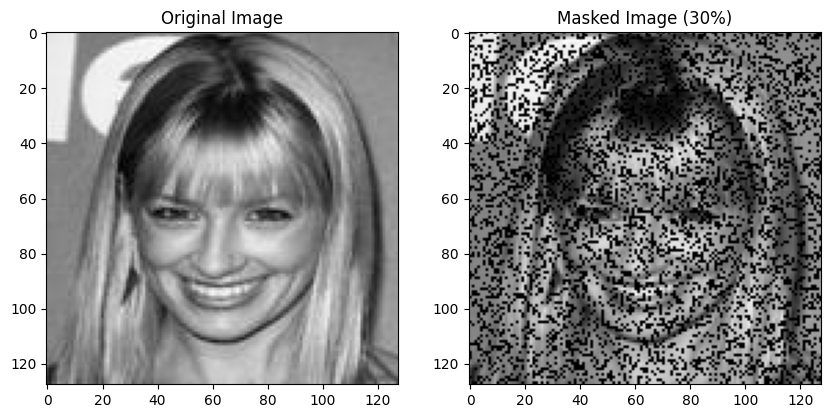

In [27]:
# Kinda scary example
masked_image, mask = mask_entries(images[2])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(images[2], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Masked Image (30%)")
plt.imshow(masked_image, cmap="gray")
plt.show()

In [28]:
# MSE as described in proposal
def calculate_mse(original, predicted, mask):
    error = original[mask] - predicted[mask]
    mse = np.mean(error ** 2)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    return mse

In [32]:
# simple SVD example to see what results we can expect

image = images[2]
m, n = image.shape  # Image dimensions

masked_image, mask = mask_entries(image, sparsity_level=0.3)

# Initialize U and V randomly
k = 50  # Number of latent factors
U = np.random.normal(scale=1.0/k, size=(m, k))
V = np.random.normal(scale=1.0/k, size=(n, k))

# Hyperparameters
learning_rate = 0.01
regularization = 0.1
num_epochs = 1000

# Get observed pixel indices
observed_pixels = np.array([(i, j) for i in range(m) for j in range(n) if not mask[i, j]])

# Stochastic Gradient Descent (SGD) for Matrix Completion
for epoch in range(num_epochs):
    np.random.shuffle(observed_pixels)  # Shuffle observed pixels
    total_error = 0

    for i, j in observed_pixels:
        error = image[i, j] - np.dot(U[i, :], V[j, :].T)  # Compute error
        U[i, :] += learning_rate * (error * V[j, :] - regularization * U[i, :])  # Update U
        V[j, :] += learning_rate * (error * U[i, :] - regularization * V[j, :])  # Update V
        total_error += error**2

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Error: {total_error:.4f}")


Epoch 0, Error: 3470.0054
Epoch 100, Error: 451.1402
Epoch 200, Error: 408.5251
Epoch 300, Error: 407.7943
Epoch 400, Error: 408.2026
Epoch 500, Error: 406.6577
Epoch 600, Error: 406.9624
Epoch 700, Error: 408.0181
Epoch 800, Error: 407.2934
Epoch 900, Error: 406.9414


In [35]:
# Reconstruct missing pixels
reconstructed_image = np.dot(U, V.T)

# Replace observed pixels with original values
final_image = image.copy()
final_image[mask] = reconstructed_image[mask]

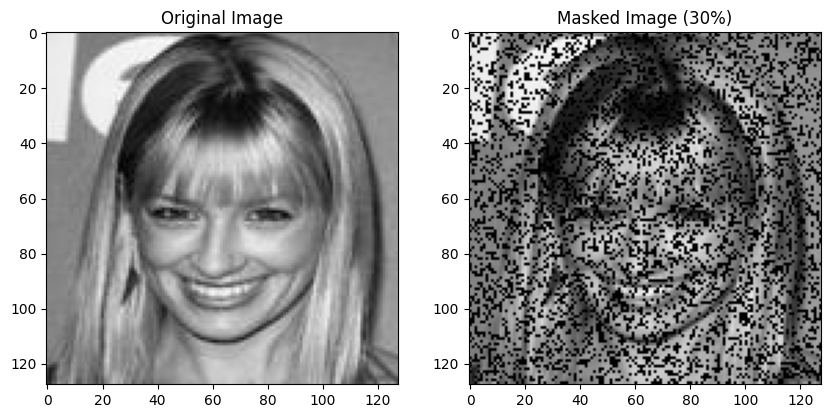

In [36]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(images[2], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Masked Image (30%)")
plt.imshow(masked_image, cmap="gray")
plt.show()

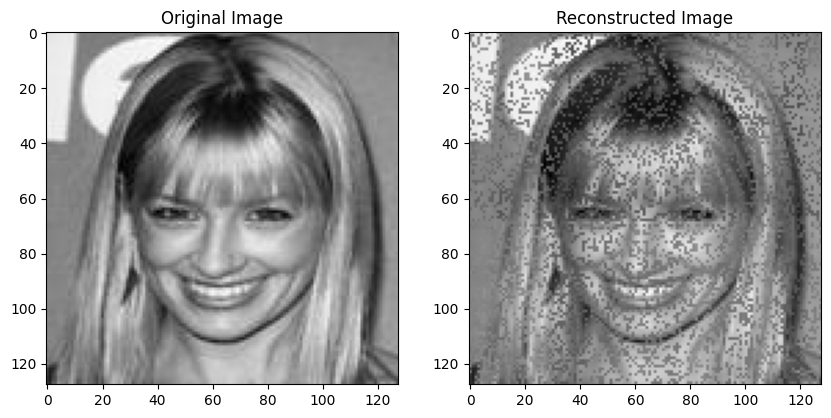

In [37]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(images[2], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(final_image, cmap="gray")
plt.show()